In [31]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [32]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [33]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [34]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [35]:
df = preprocess_german(df)

In [36]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [37]:
len(y)

1000

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=15)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [39]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [40]:
#calculate the influence of each train data point by retraining


In [41]:
#SCIKIT LEARN LR

# def demographic_parity(x_train, y_train, x_test, y_test):
#     # find the predictive probabilities for the protected and privileged groups based on 'age'
 
#     logistic_model = LogisticRegression(max_iter=1000)
#     logistic_model.fit(x_train, y_train.values.ravel())

#     x_test = x_test.reset_index(drop=True)
#     y_pred_proba = logistic_model.predict_proba(x_test)

#     privileged_gp_indices = x_test[x_test['age']==1].index
#     protected_gp_indices = x_test[x_test['age']==0].index

#     privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
#     protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()

#     return  privileged_positive_pred - protected_positive_pred


In [42]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    logistic_model = LogisticRegression(input_size=x_train_temp.shape[1], epoch_num=1000)
    logistic_model.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = logistic_model.predict_proba(x_test_scalar_temp)
    print(y_pred_proba_temp.shape)
    print(y_pred_proba_temp)

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index
    # y_pred_proba returns an array, how do we know whether that is for the positive label or negative label.
    # assuming it gives us the probability of the positive class

    for x in range(len(privileged_gp_indices)):
        sum_pri = 0
        count_pri = 0
        # if y_pred_proba_temp[x] > 0.5:
        sum_pri += y_pred_proba_temp[x]
        count_pri += 1
    privileged_positive_pred = sum_pri/count_pri

    for x in range(len(protected_gp_indices)):
        sum_pro = 0
        count_pro = 0
        # if y_pred_proba_temp[x] > 0.5:
        sum_pro += y_pred_proba_temp[x]
        count_pro += 1
    protected_positive_pred = sum_pro/count_pro

    # privileged_positive_pred = y_pred_proba[privileged_gp_indices, 1][y_pred_proba[privileged_gp_indices, 1] > 0.5].mean()
    # protected_positive_pred = y_pred_proba[protected_gp_indices, 1][y_pred_proba[protected_gp_indices, 1] > 0.5].mean()

    return privileged_positive_pred - protected_positive_pred

In [43]:
dp_ori = demographic_parity(x_train, y_train, x_test)

(200,)
[0.5963561  0.29436707 0.89419657 0.7011282  0.645822   0.8177548
 0.6942958  0.20115526 0.41753227 0.32348552 0.6308133  0.81527543
 0.30774358 0.49401    0.48665327 0.7722582  0.77549845 0.58834726
 0.6790581  0.88533086 0.34771356 0.7881899  0.5149792  0.51549387
 0.79252714 0.88281727 0.69174147 0.7947596  0.8773997  0.6139605
 0.8287647  0.80343664 0.7303087  0.7065015  0.78340447 0.47932363
 0.51362026 0.8244205  0.4665255  0.71167374 0.5660176  0.6783549
 0.37390667 0.7644138  0.26814604 0.8550458  0.36447245 0.8634863
 0.5085196  0.30160797 0.7386111  0.85732335 0.7527393  0.77583873
 0.6442058  0.70527416 0.43014818 0.7553316  0.7414636  0.4755082
 0.7609174  0.84093624 0.45762876 0.8700265  0.89438397 0.8829907
 0.57568014 0.6440169  0.5339389  0.33183324 0.73655546 0.40194947
 0.8808234  0.853271   0.5696221  0.5850628  0.90664613 0.6889255
 0.35158786 0.36044043 0.34443274 0.33284256 0.5418453  0.40696752
 0.74930125 0.72174525 0.6968184  0.90666246 0.56321883 0.7082

In [44]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

# x_train_a = np.copy(x_train)
# y_train_a = np.copy(y_train)

# result = []

# for i in range(len(x_train)):
#     x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
#     y_train_new = np.append(y_train_a, [y_train[i]])
#     result.append(demographic_parity(x_train_new, y_train_new, x_test) - dp_ori)

# print(result)


In [45]:
# np.save('trained_dp.npy', result)

In [47]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [48]:
del_F_del_theta = del_predictive_parity_del_theta(clf, x_test_orig, x_test_scalar, y_test)
print(del_F_del_theta.shape)
print(type(del_F_del_theta))

(19,)
<class 'numpy.ndarray'>


In [49]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


100%|██████████| 800/800 [00:05<00:00, 137.03it/s]


In [50]:
print(hessian_all_points.shape)

(800, 19, 19)


In [51]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [52]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [53]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [54]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))  #it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [55]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
print(inf.shape)

(800,)


In [56]:
print(type(inf))


<class 'numpy.ndarray'>


In [57]:
print(inf)

[-3.06185883e-01  3.39309248e-01  3.50358758e-01 -5.26500297e-01
  4.41162329e-01 -3.93065083e-01 -5.16251333e-01  1.61961777e-01
 -1.89790352e-01 -2.61654451e-01  2.74583229e-01 -3.51719822e-01
  3.31920757e-01 -6.81674118e-01  2.56428930e-02 -1.05704044e-01
 -1.79831331e-01 -3.43154615e-01 -3.20831685e-01  2.52802808e-01
 -3.67429031e-01  1.45629820e-02  1.07242431e-01  4.47832574e-01
  1.51857050e-01 -1.74769724e-01 -1.42522362e-01  2.75144096e-01
 -6.12195207e-01  3.08770460e-01 -3.82878619e-01 -7.53402105e-02
 -6.84897879e-02  4.14619834e-01 -1.86864245e-01  1.34986302e-01
  4.10888962e-01 -1.03459999e-01 -2.30580679e-01 -4.52482810e-01
  1.75869137e-01 -2.06953004e-01  2.98720570e-01  3.29855478e-01
  3.75178039e-01  2.34655624e-01  1.49794306e-01  4.31796023e-01
  5.52825883e-02 -4.63240005e-02  3.13809055e-02  1.04425461e-01
 -4.86584840e-02  4.43900150e-01 -1.07413000e+00 -3.24642823e-01
  4.97244882e-01 -5.60594086e-01 -8.61213867e-02 -1.12352401e-02
 -5.00605876e-01 -3.06635

In [58]:
result = np.load('trained_dp.npy')
trained_arr = np.array(result)

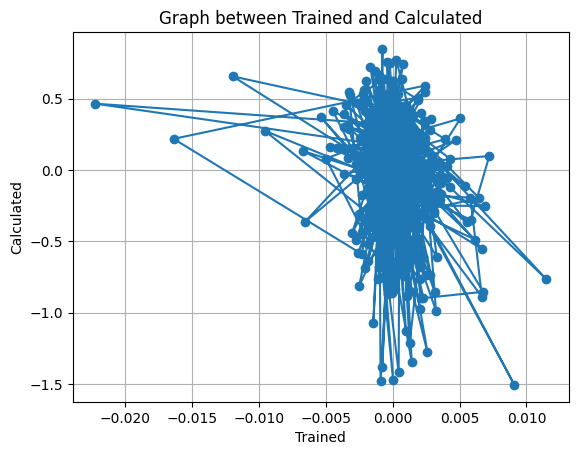

In [59]:
import matplotlib.pyplot as plt
df = pd.DataFrame({'Trained': trained_arr, 'Calculated': inf})
plt.plot(df['Trained'], df['Calculated'], marker='o', linestyle='-')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained')
plt.ylabel('Calculated')
plt.grid(True)
plt.show()